In [37]:
import os
import numpy as np
import pandas as pd
from arcgis import GIS
from arcgis.features import GeoAccessor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
from matplotlib import pyplot as plt

# # show all columns
# pd.options.display.max_columns = None

plt.rcParams.update({'figure.figsize': (14.0, 10.0)})
plt.rcParams.update({'font.size': 14})

In [16]:
outputs = r'.\Outputs'
if not os.path.exists(outputs):
    os.makedirs(outputs)

In [14]:
# read in inputs
b_vars = pd.read_csv(r".\Inputs\run423year2019allbuildings.csv")
n_vars = pd.read_csv(r".\Inputs\run423year2019nodevariables.csv")
z_vars = pd.read_csv(r".\Inputs\run423year2019zonalvariables.csv")

# rename identical columns
b_vars.rename({'population':'population_b'}, axis=1, inplace=True)
z_vars.rename({'population':'population_z'}, axis=1, inplace=True)

# join utm coords 
parcels = r"E:\REMM\Base_Year_Data_2019\v1\remm_base_year_20220513.gdb\parcels_2019"
parcels = pd.DataFrame.spatial.from_featureclass(parcels)[['parcel_id_REMM', 'x', 'y']].copy()
parcels.columns = ['parcel_id', 'utmxi','utmyi']
b_vars = b_vars.merge(parcels, on='parcel_id', how='left')
del parcels

In [15]:
# check for duplicates
b_vars_names = list(b_vars.columns)
n_vars_names = list(n_vars.columns)
z_vars_names = list(z_vars.columns)

all_names = b_vars_names + n_vars_names + z_vars_names
seen = set()
dupes = [name for name in all_names if name in seen or seen.add(name)]
print(dupes)   

['node_id', 'zone_id']


In [22]:
# combine variables
tbl = b_vars.merge(z_vars, on='zone_id', how='left')
tbl = tbl.merge(n_vars, on='node_id', how='left')

tbl['log1p_fwy_exit_dist_tdm_output'] = np.log1p(tbl['fwy_exit_dist_tdm_output'])
tbl['log1p_rail_stn_dist'] =  np.log1p(tbl['rail_stn_dist'])
tbl['log1p_sqft_per_unit'] =  np.log1p(tbl['sqft_per_unit'])
tbl['log1p_university_dist'] = np.log1p(tbl['university_dist'])

tbl.loc[(tbl['avg_building_age'] < 21), 'avg_building_age_lt_21'] = 1
tbl.loc[~(tbl['avg_building_age'] < 21), 'avg_building_age_lt_21'] = 0

tbl.loc[(tbl['year_built'] < 21), 'year_built_lt_1945'] = 1
tbl.loc[~(tbl['year_built'] < 21), 'year_built_lt_1945'] = 0

In [23]:
# create tables for each county
tbl_57 = tbl[tbl['county_id']==57].copy()
tbl_11 = tbl[tbl['county_id']==11].copy()
tbl_35 = tbl[tbl['county_id']==35].copy()
tbl_49 = tbl[tbl['county_id']==49].copy()

# tbl_57.to_csv(os.path.join(outputs, 'buildings_nodes_zones_57.csv'), index=False)
# tbl_11.to_csv(os.path.join(outputs, 'buildings_nodes_zones_11.csv'), index=False)
# tbl_35.to_csv(os.path.join(outputs, 'buildings_nodes_zones_35.csv'), index=False)
# tbl_49.to_csv(os.path.join(outputs, 'buildings_nodes_zones_49.csv'),index=False)

In [24]:
vars_to_exclude = ['parcel_id', 'building_id', 'note', 'zone_1212']

In [25]:
# drop columns
tbl_57.drop(vars_to_exclude, axis=1, inplace=True)
tbl_11.drop(vars_to_exclude, axis=1, inplace=True)
tbl_35.drop(vars_to_exclude, axis=1, inplace=True)
tbl_49.drop(vars_to_exclude, axis=1, inplace=True)

## Single Family Residential Unit Price Model

###  Weber

In [26]:
old_vars =  ['ave_income_500',
             'commute_time',
             'distmed_1',
             'distmed_2',
             'distmed_3',
             'distmed_4',
             'distmed_5',
             'distmed_6',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'log1p_rail_stn_dist', # np.log1p(rail_stn_dist)
             'log1p_sqft_per_unit', # np.log1p(sqft_per_unit)
             'log1p_university_dist', # np.log1p(university_dist)
             'parcel_volume',
             'avg_building_age_lt_21',  #I(avg_building_age < 21)[T.True],
             'year_built_lt_1945', #I(year_built < 1945)[T.True]
            ]

In [29]:
# arguments - check these
data = tbl_57
y_var = 'res_price_per_sqft'

In [30]:
# filters
sf = data[(data['building_type_id'] == 1) & (data['res_price_per_sqft'] > 0)]

# get desired columns
sf = sf[old_vars + [y_var]]

# separate independent and dependent variables
x_vars = sf[old_vars].copy()
y_var = sf[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)

In [31]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 0.878
Mean Squared Error: 1.917
R-squared scores: 0.985


Text(0.5, 0, 'Random Forest Feature Importance')

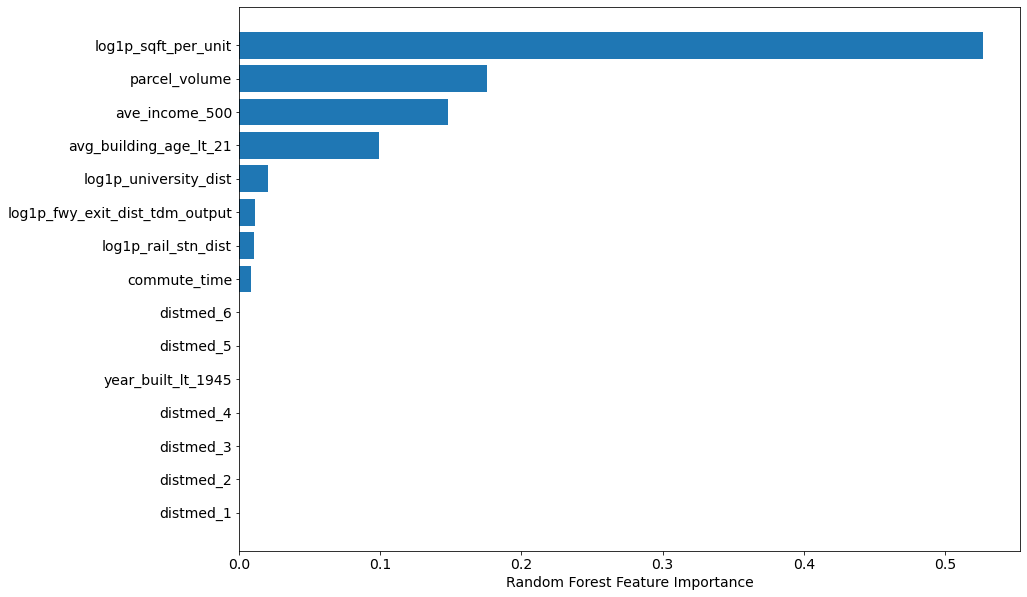

In [38]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Davis

In [51]:
old_vars =  ['ave_income_500',
             'commute_time',
             'distmed_10',
             'distmed_11',
             'distmed_12',
             'distmed_7',
             'distmed_8',
             'distmed_9',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'log1p_rail_stn_dist', # np.log1p(rail_stn_dist)
             'log1p_sqft_per_unit', # np.log1p(sqft_per_unit)
             'log1p_university_dist', # np.log1p(university_dist)
             'parcel_volume',
             'avg_building_age_lt_21',  #I(avg_building_age < 21)[T.True],
             'year_built_lt_1945', #I(year_built < 1945)[T.True]
            ]

In [52]:
# arguments - check these
data = tbl_11
y_var = 'res_price_per_sqft'

In [53]:
# filters
sf = data[(data['building_type_id'] == 1) & (data['res_price_per_sqft'] > 0)]

# get desired columns
sf = sf[old_vars + [y_var]]

# separate independent and dependent variables
x_vars = sf[old_vars].copy()
y_var = sf[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)

In [54]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 0.906
Mean Squared Error: 6.886
R-squared scores: 0.983


Text(0.5, 0, 'Random Forest Feature Importance')

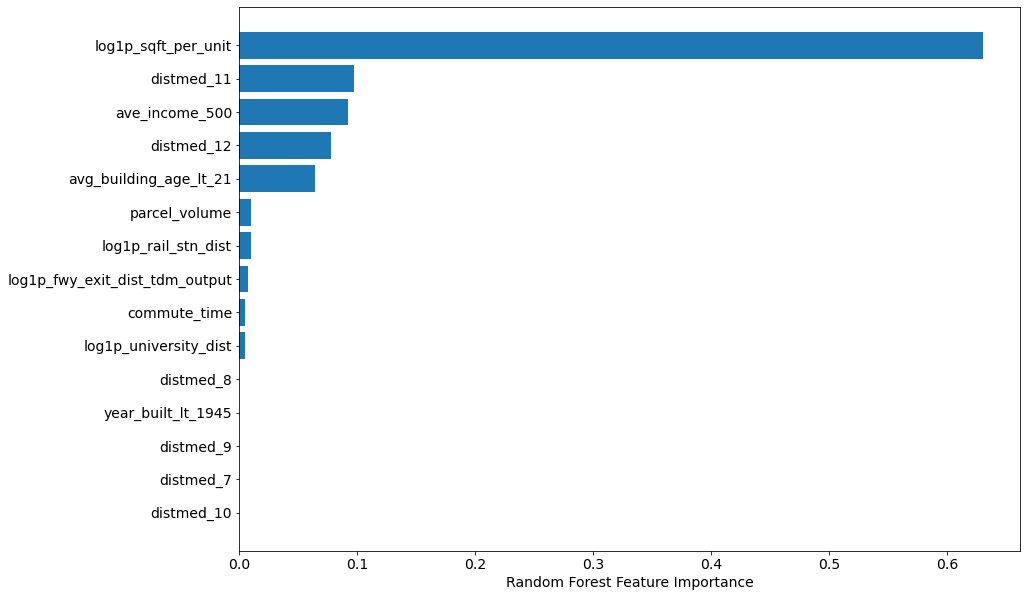

In [55]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Salt Lake

In [56]:
old_vars =  ['ave_income_500',
             'commute_time',
             'distmed_13',
             'distmed_14',
             'distmed_15',
             'distmed_16',
             'distmed_17',
             'distmed_18',
             'distmed_19',
             'distmed_20',
             'distmed_21',
             'distmed_22',
             'distmed_23',
             'distmed_24',
             'distmed_25',
             'distmed_26',
             'distmed_27',
             'distmed_28',
             'distmed_29',
             'distmed_30',
             'distmed_31',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'log1p_rail_stn_dist', # np.log1p(rail_stn_dist)
             'log1p_sqft_per_unit', # np.log1p(sqft_per_unit)
             'log1p_university_dist', # np.log1p(university_dist)
             'parcel_volume',
             'avg_building_age_lt_21',  #I(avg_building_age < 21)[T.True],
             'year_built_lt_1945', #I(year_built < 1945)[T.True]
            ]

In [57]:
# arguments - check these
data = tbl_35
y_var = 'res_price_per_sqft'

In [58]:
# filters
sf = data[(data['building_type_id'] == 1) & (data['res_price_per_sqft'] > 0)]

# get desired columns
sf = sf[old_vars + [y_var]]

# separate independent and dependent variables
x_vars = sf[old_vars].copy()
y_var = sf[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)

In [59]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 0.432
Mean Squared Error: 2.846
R-squared scores: 0.987


Text(0.5, 0, 'Random Forest Feature Importance')

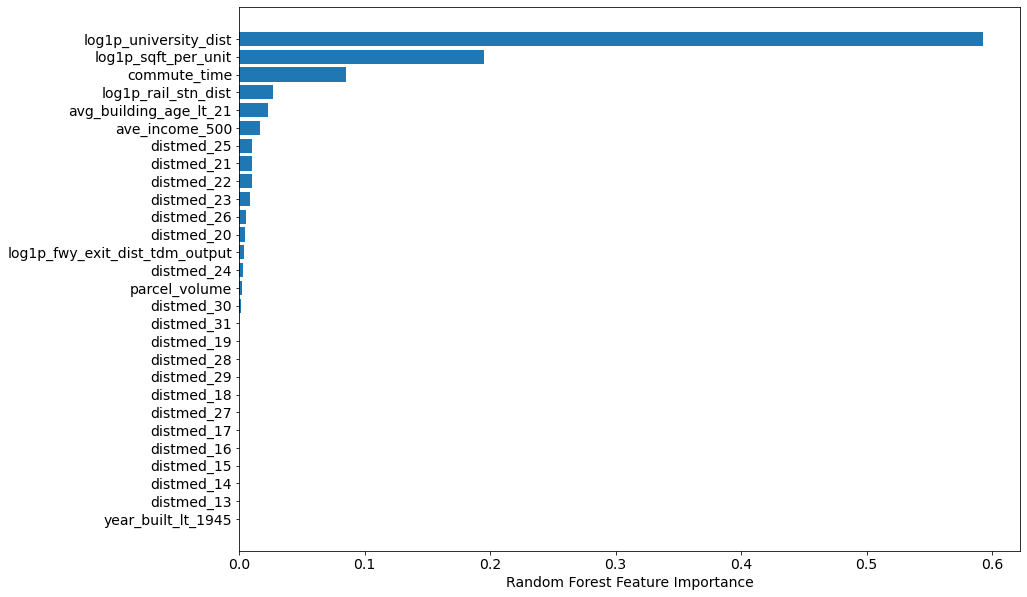

In [60]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Utah

In [61]:
old_vars =  ['ave_income_500',
             'commute_time',
             'distmed_32',
             'distmed_33',
             'distmed_34',
             'distmed_35',
             'distmed_36',
             'distmed_37',
             'distmed_38',
             'distmed_39',
             'distmed_40',
             'distmed_41',
             'log1p_fwy_exit_dist_tdm_output',   #np.log1p(fwy_exit_dist_tdm_output)
             'log1p_rail_stn_dist', # np.log1p(rail_stn_dist)
             'log1p_sqft_per_unit', # np.log1p(sqft_per_unit)
             'log1p_university_dist', # np.log1p(university_dist)
             'parcel_volume',
             'avg_building_age_lt_21',  #I(avg_building_age < 21)[T.True],
             'year_built_lt_1945', #I(year_built < 1945)[T.True]
            ]

In [62]:
# arguments - check these
data = tbl_49
y_var = 'res_price_per_sqft'

In [63]:
# filters
sf = data[(data['building_type_id'] == 1) & (data['res_price_per_sqft'] > 0)]

# get desired columns
sf = sf[old_vars + [y_var]]

# separate independent and dependent variables
x_vars = sf[old_vars].copy()
y_var = sf[y_var]

# split into training and testing
x_train, x_test, y_train, y_test = train_test_split(x_vars, y_var, test_size=0.25, random_state=33)

In [64]:
#===========================================
# create the model and calculate accuracy
#===========================================

rf = RandomForestRegressor(n_jobs= -1, n_estimators=100)
rf.fit(x_train, y_train)

predictions = rf.predict(x_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 3))
print('Mean Squared Error:', round(mse, 3))
print('R-squared scores:', round(r2, 3))

Mean Absolute Error: 0.386
Mean Squared Error: 4.112
R-squared scores: 0.948


Text(0.5, 0, 'Random Forest Feature Importance')

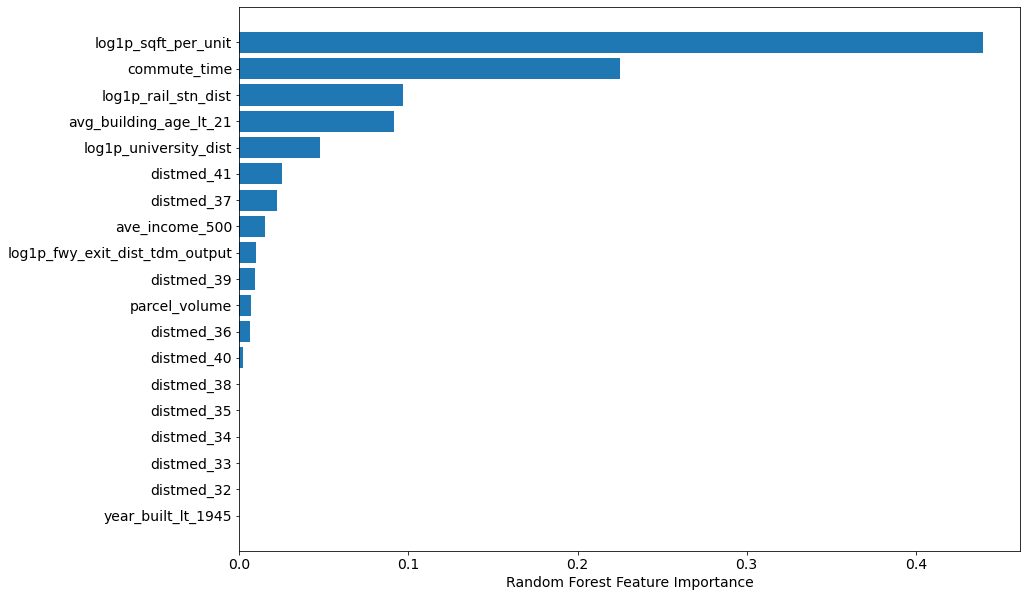

In [65]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x_vars.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [ ]:
# mf = buildings[(buildings['building_type_id']==2) & (buildings['res_price_per_sqft'] >0)]

In [12]:
# alternate permutation importance method
# perm_importance = permutation_importance(rf, x_test, y_test)
# sorted_idx = perm_importance.importances_mean.argsort()
# plt.barh(x_vars.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
# plt.xlabel("Permutation Importance")